# Block Creation of Rotated Input Point Cloud

Following the successful rotation of the input point cloud, we will now presume with the block creation of the input point cloud. This is an essential operation, as it guarantees a stable information inflow into our model. Therefore, the ideal blocking strategy will be outlined and tested below. In order to get a feeling for the entire pre-processing of the input point cloud, the back-rotation of the point cloud wil be performed here once more before we get into the block creation for the sample.

## Imports

In [325]:
# For paths
import os 

# For data processing
import numpy as np
import math

# For 3D visualization
import open3d as o3d
import matplotlib.pyplot as plt

## Functions

In [326]:
# Setting the root for this repo
ROOT = os.path.realpath("..")

# Creating/ Making the point cloud
def makePC(point_data, color_data=np.array([])):
    pcd = o3d.geometry.PointCloud() #Create PC object
    pcd.points = o3d.utility.Vector3dVector(point_data) #Give coordinates
    #Coloring the PC
    if len(color_data) == 0:
        pcd.paint_uniform_color([1, 0, 0])
    else:
        pcd.colors = o3d.utility.Vector3dVector(color_data)
    return pcd

# Retrieve lowest corner fo the cuboid/ bounding box
def get_lowest_corner_coords(cuboid_coords, axis):
    ''' 
    inputs:
    - cuboid_coords: 8x3-array of cuboid vertice coordinates
    - axis: string determining in which direction one wants to retrieve the "lowest corner"
    
    return:
    - lowest_corner_coords: 1x3-array with the coordinates of the "lowest" corner in the specified direction
    '''
    if axis == 'z':
        z_val_lowest_corner = np.min(cuboid_coords[:,2])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == z_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == z_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == z_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    elif axis == 'y':
        y_val_lowest_corner = np.min(cuboid_coords[:,1])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == y_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == y_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == y_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    elif axis == 'x':
        x_val_lowest_corner = np.min(cuboid_coords[:,0])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == x_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == x_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == x_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    return lowest_corner_coords

# Create norm of passed vector
def norm_vec(vector):
    '''
    input:
    - vector: 1x3-array of vector to be normed
    
    return:
    - vector norm
    '''
    return np.linalg.norm(vector)

# Creating unit vector for input vector
def unit_vector(vector):
    '''
    input:
    - vector: 1x3-array of vector to be unitized
    
    output:
    - 1x3-array of unit vector from passed vector
    '''
    return vector / np.linalg.norm(vector)

# Create vector array of start and end point array
def create_vectors(start_end_point_array):
    '''
    This function returns an array of 3D vectors from a start and end point array.
    
    input:
    - start_end_point_array: array of starting and end points of vectors
    
    return:
    - vec_return: array of 3D vectors
    '''
    # Creation of empty vector list to be filled
    vec_return = np.zeros((len(start_end_point_array), 3))
    for i in range(len(start_end_point_array)):
        vec_i = start_end_point_array[i][1] - start_end_point_array[i][0]
        vec_return[i] = vec_i
    return vec_return

# Create ascendingly sorted vector distances array
def create_vec_distances(vectors):
    '''
    input:
    - vectors: coordinates of vectors whose distances shall be calculated
    
    return:
    - vector_dists: vector distances
    '''
    vector_dists_list = []
    for i in range(len(vectors)):
        vector_i_dist = norm_vec(vectors[i])
        vector_dists_list.append(vector_i_dist)
    vector_dists = np.array(vector_dists_list)
    return vector_dists

def get_orthonormal_vec_coords(orthonnormal_vec_coords, which):
    '''
    inputs:
    - orthogonal_vec_coords: coordinates of the 3 orthonormal vectors
    - which: string-argument specifying which of the orthonormal vector coordinates to be retrieved
        - longest: x-edge of the bounding box
        - middle: y-edge of the bounding box
        - shortest: z-edge of the bounding box
    
    return:
    - dist_sorted_orthogonal_vec_coords[i]: 1x3-array of corresponding orthonormal vector
    '''
    orthogonal_vec_dists = create_vec_distances(orthonnormal_vec_coords)
    # Sort coordinate list as the distance list 
    dist_sorted_indices = orthogonal_vec_dists.argsort()
    dist_sorted_orthognal_vec_coords = orthonnormal_vec_coords[dist_sorted_indices]
    if which == 'longest':
        return dist_sorted_orthognal_vec_coords[2]
    elif which == 'middle':
        return dist_sorted_orthognal_vec_coords[1]
    elif which == 'shortest':
        return dist_sorted_orthognal_vec_coords[0]
    else:
        print('Argument -which- was specified incorrectly, please correct.')

# Find R for aligning vec1 with vec2
def rot_mat_from_vecs(vec1, vec2):
    '''
    Find rotation matrix aligning vec1 with vec 2 (based in Rodrigues' rotation formula)
    
    inputs:
    - vec1: vector to be aligned | 1x3-array
    - vec2: vector to be aligned with | 1x3-array
    
    return:
    - rot_mat: rotation matrix rotating vec1 onto vec2
    '''
    vec1_uv, vec2_uv = unit_vector(vec1).reshape(3), unit_vector(vec2).reshape(3)
    v = np.cross(vec1_uv, vec2_uv)
    c = np.dot(vec1_uv, vec2_uv)
    s = norm_vec(v)
    kmat = np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])
    rot_mat = np.eye(3) + kmat + kmat.dot(kmat) * ((1-c) / (s**2))
    return rot_mat

# Rotate coordinates with rotation amtrix for axis alignment
def rotate_coords_onto_axis(coords, R):
    ''' 
    Function that rotates the given points by the given rotation matrix.
    
    input:
    - coords: coordinates of points to be rotated
    - R: rotation amtrix by which the points should be rotated
    
    return:
    coords_rot: rotated point coordinates
    '''
    # Depending on shape of coordinates passed rotation multiplication adjustment
    if coords.shape == (3,):
        coords_rot = R.dot(coords)
    coords_rot_list = []
    for i in range(len(coords)):
        coords_i_rot = R.dot(coords[i])
        coords_rot_list.append(coords_i_rot)
    coords_rot = np.array(coords_rot_list)
    return coords_rot

# Loading of Data

For a start we will first of all load in the input pc in its raw form, before rotating and translating it back to the origin as a center. 

In [327]:
# Path to input data
input_data_path = "/Users/nk/Documents/GitHubRepos/Pointnet_Pointnet2_pytorch/data/testdata/data_labelled_int.npy"

# Load the input data
input_pc = np.load(input_data_path)

# Assigning xyz values
x_original = input_pc[:,0]
y_original = input_pc[:,1]
z_original = input_pc[:,2]
# Creating entire coords array for rotation
input_pc_coords = input_pc[:, 0:3]
# Assigning color channels
red_c = input_pc[:, 3]
green_c = input_pc[:, 4]
blue_c = input_pc[:, 5]
#Shifting color range ot be between [0, 1]
red_c = (red_c - np.min(red_c)) / (np.max(red_c) - np.min(red_c))
green_c = (green_c - np.min(green_c)) / (np.max(green_c) - np.min(green_c))
blue_c = (blue_c - np.min(blue_c)) / (np.max(blue_c) - np.min(blue_c))
# Creating individual color arrray
rgb_list = np.ones((input_pc.shape[0], 3))
rgb_list[:, 0] = red_c
rgb_list[:, 1] = green_c
rgb_list[:, 2] = blue_c 

# Back rotation of input point cloud

First we will start with rotating the input cloud back to be centered on the origin and facing upwards, meaning the shortest/ z-edge points upwards in z-direction.

## Cropping of input point cloud and getting bounding box

In [328]:
# Stacking coordinates of input pc
input_pc_coords = np.stack([x_original, y_original, z_original], axis=1)

# Making point cloud to be displayed
viz_pc = makePC(input_pc_coords, rgb_list)

# Cropping pc with oriented bounding box
bbox_to_crop = viz_pc.get_oriented_bounding_box()
bbox_color = (0, 1, 0)
viz_pc_cropped = viz_pc.crop(bbox_to_crop)
bbox_original = viz_pc_cropped.get_oriented_bounding_box()

# Get bounding box corner points
bbox_points = np.round(np.asarray(bbox_original.get_box_points()), 2)

## Pulling of orthonormal vector trio

In [329]:
# retrieving lowest corner in z-direction
lowest_corner_coords = get_lowest_corner_coords(bbox_points, axis='z')

# Construction of vectors to all other points
lowest_corner_to_corner_vectors_list = []
for i in range(len(bbox_points)):
    vec_i = bbox_points[i] - lowest_corner_coords
    # Skip vec to same corner as lowest
    if (vec_i == np.array([0, 0, 0])).all():
        continue
    lowest_corner_to_corner_vectors_list.append(vec_i)
lowest_corner_to_corner_vectors = np.array(lowest_corner_to_corner_vectors_list)

# Determining distances ot choose the shortest to be aligned with z-axis
lowest_corner_to_corner_dists = create_vec_distances(lowest_corner_to_corner_vectors)
shortest_idx = np.argmin(lowest_corner_to_corner_dists)
shortest_lowest_corner_to_corner_vector_coords = lowest_corner_to_corner_vectors[shortest_idx]

# Calculating the dot product to find orthonormal vecs
orthonormal_vec_coords_list = []
for i in range(len(lowest_corner_to_corner_vectors)):
    dot_product_result = np.dot(
        unit_vector(shortest_lowest_corner_to_corner_vector_coords),
        unit_vector(lowest_corner_to_corner_vectors[i])
    )
    if np.round(dot_product_result, 2) <= 0.00001:
        orthonormal_vec_coords_list.append(lowest_corner_to_corner_vectors[i])

# Filtering out the longest orthogonal vector adn replace with the shortest
orthonormal_vec_dists = create_vec_distances(orthonormal_vec_coords_list)
longest_idx = np.argmax(orthonormal_vec_dists)
del orthonormal_vec_coords_list[longest_idx]
orthonormal_vec_coords_list.append(shortest_lowest_corner_to_corner_vector_coords)
orthonormal_vec_coords = np.array(orthonormal_vec_coords_list)

## First back-rotation

Aligning the z-edge with the z-axis.

In [330]:
# Pulling coordinates of the shortest orthonormal vector
z_edge = get_orthonormal_vec_coords(orthonormal_vec_coords, 'shortest')

# Retrieving the rotation matrix to align with z-axis
R_rot1 = rot_mat_from_vecs(z_edge, np.array([0, 0, 1]))

# Rotating the points
input_pc_rot1 = rotate_coords_onto_axis(input_pc_coords, R_rot1)
# Rotating orthonormal vectors
orthonormal_vec_coords_rot1 = rotate_coords_onto_axis(orthonormal_vec_coords, R_rot1)

## Second back-rotation

Aligning x-edge with x-axis.

In [331]:
# Pulling coordinates of the shortest orthonormal vector
x_edge = get_orthonormal_vec_coords(orthonormal_vec_coords_rot1, 'longest')

# Retrieving the rotation matrix to align with z-axis
R_rot2 = rot_mat_from_vecs(x_edge, np.array([1, 0, 0]))

# Rotating the points
input_pc_rot2 = rotate_coords_onto_axis(input_pc_rot1, R_rot2)
# Rotating orthonormal vectors
orthonormal_vec_coords_rot2 = rotate_coords_onto_axis(orthonormal_vec_coords_rot1, R_rot2)

## Centering of back-rotated input point cloud

In [332]:
# Define center of the point cloud
pc_center = np.mean(input_pc_rot2, axis=0)

# Centering the pc
input_rot2_centered = input_pc_rot2 - pc_center

## Visualization of final back-rotated and centered point cloud

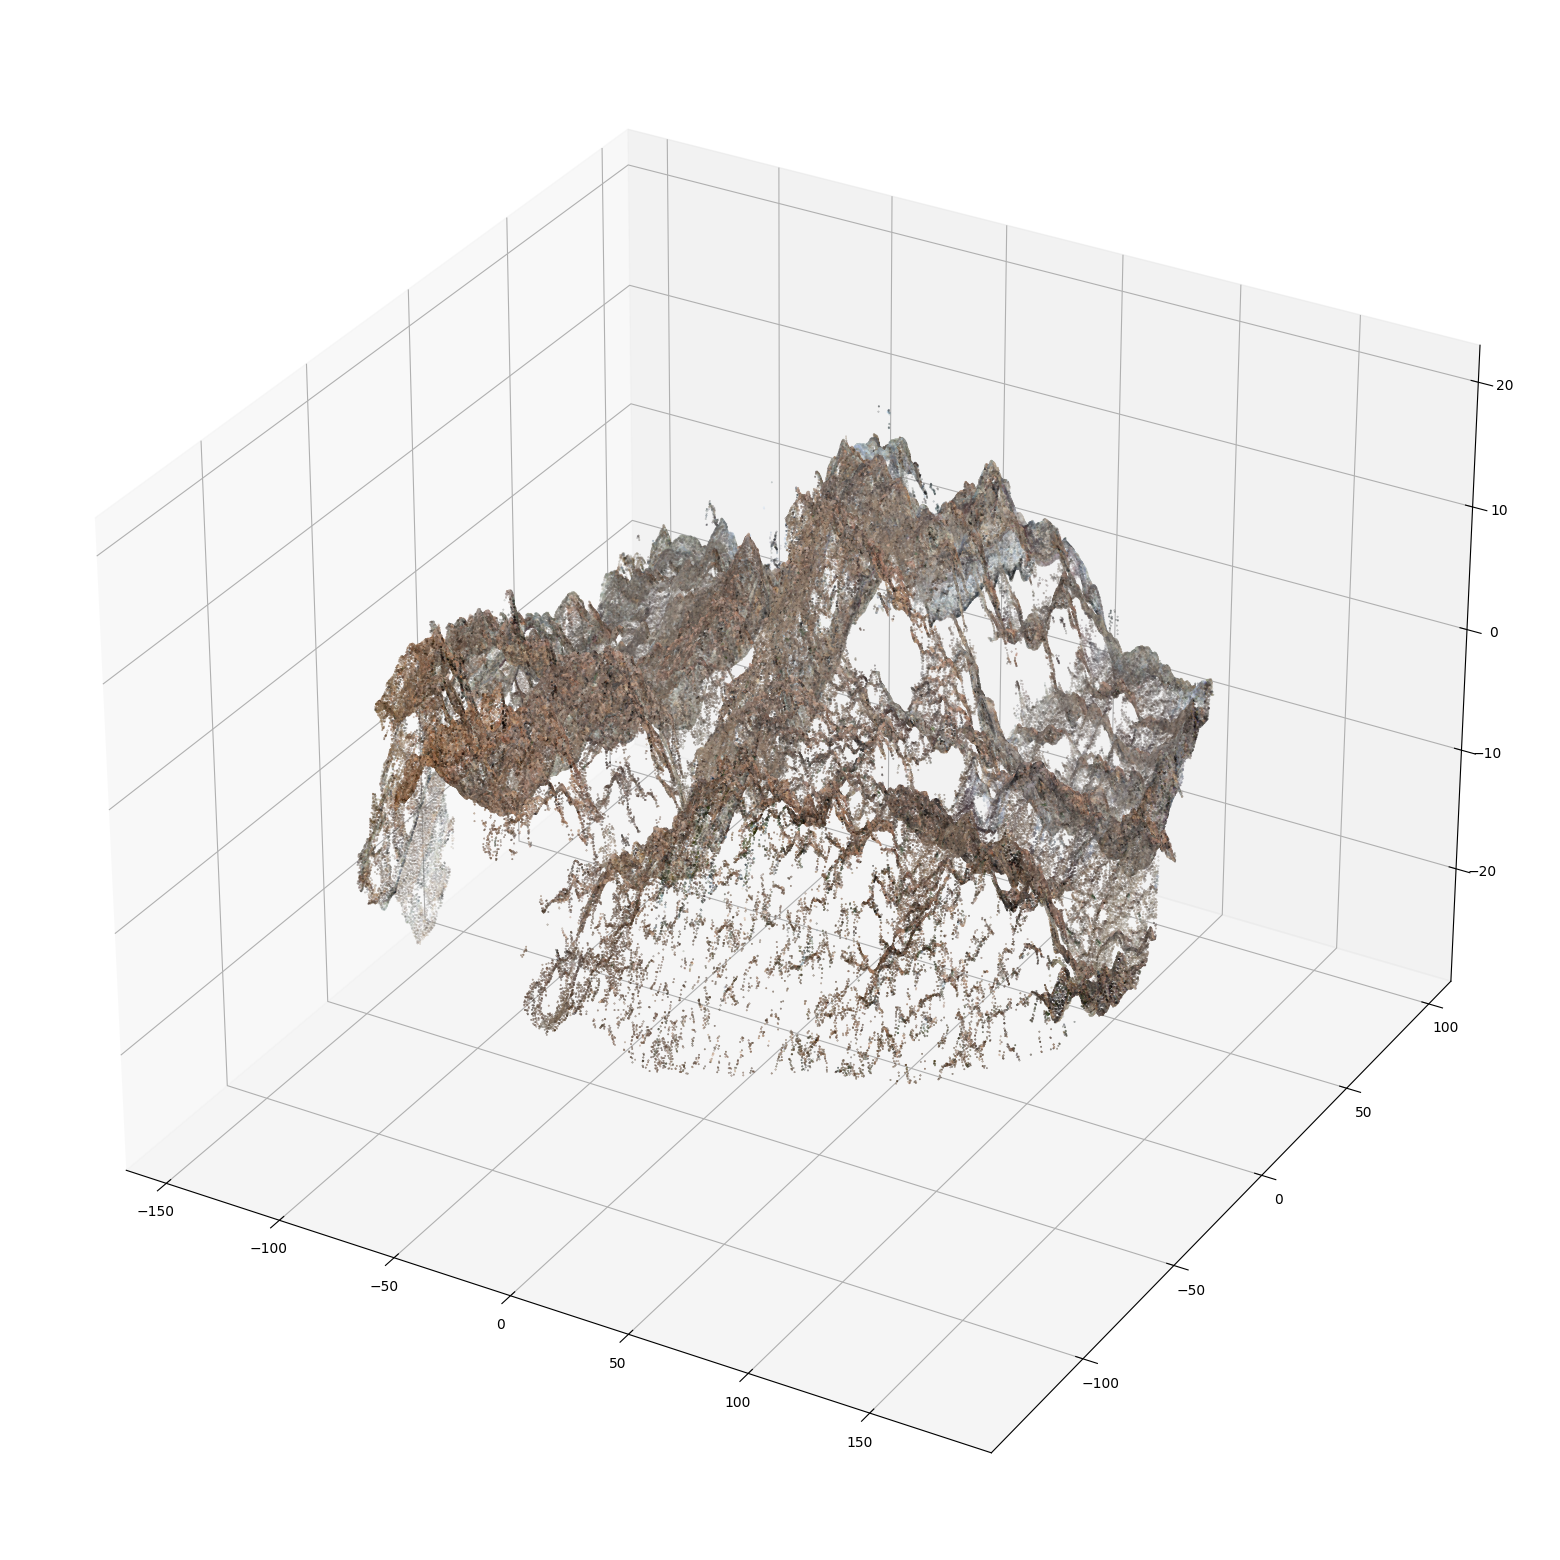

In [333]:
# Assigning xyz values - c for centered
x_c = input_rot2_centered[:,0]
y_c = input_rot2_centered[:,1]
z_c = input_rot2_centered[:,2]

# Visualization
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_c, y_c, z_c, c=rgb_list, s=0.1)
plt.show()

# Analysis of back-rotated and centered point cloud

Before we go into the nitty gritty details of the blocking and how it is done in detail, we will shortly analyse the back-rotated and centered point cloud to derive the smartest blocking solution for it.

In [334]:
# Combination of rotated coords with colors and labels
final_input_pc = np.zeros((len(input_rot2_centered), 6))
final_input_pc[:, 0:3] = input_rot2_centered # Coordinates
final_input_pc[:, 3:6] = input_pc[:, 3:6] # Colors and labels
final_input_pc_labels = input_pc[:, 6] # Colors and labels

# Simple print checks
print(f'The total amount of points in the resulting PC is: {len(input_rot2_centered)}')
print(f'The total amount of fracture points in this sample is: {np.count_nonzero(final_input_pc_labels == 1)}')
print(f'Therefore, there is this amount non-fracture points: {np.count_nonzero(final_input_pc_labels == 0)}')
print(f'The minimum coordinate in x-direction is: {np.min(final_input_pc[:,0])}')
print(f'The maximum coordinate in x-direction is: {np.max(final_input_pc[:,0])}')
print(f'The minimum coordinate in y-direction is: {np.min(final_input_pc[:,1])}')
print(f'The maximum coordinate in y-direction is: {np.max(final_input_pc[:,1])}')
print(f'The minimum coordinate in z-direction is: {np.min(final_input_pc[:,2])}')
print(f'The maximum coordinate in z-direction is: {np.max(final_input_pc[:,2])}')
print(f'The center of this PC is: {np.mean(final_input_pc[:,0:3], axis=0)[:3]}')

The total amount of points in the resulting PC is: 662525
The total amount of fracture points in this sample is: 8199
Therefore, there is this amount non-fracture points: 654326
The minimum coordinate in x-direction is: -144.4841114934353
The maximum coordinate in x-direction is: 175.96135404839993
The minimum coordinate in y-direction is: -131.94752738711134
The maximum coordinate in y-direction is: 97.07156061150204
The minimum coordinate in z-direction is: -26.28438643535324
The maximum coordinate in z-direction is: 19.589113616759782
The center of this PC is: [ 1.23859435e-12 -2.61312163e-13  1.29345033e-12]


From this we can see that there is quite a difference in the density of the points, as the mean-center of the point cloud is located at the origin, while the minima and maxima are not symmetrically distanced to the origin. We will now take a look at the outer edge point density to understand whether we should use some padding or not.

In [335]:
# Determining the min and max in each direction
x_min = np.min(final_input_pc[:,0])
x_max = np.max(final_input_pc[:,0])
y_min = np.min(final_input_pc[:,1])
y_max = np.max(final_input_pc[:,1])
z_min = np.min(final_input_pc[:,2])
z_max = np.max(final_input_pc[:,2])

# Determine the entire range in each direction
x_range = np.abs(x_min) + x_max
y_range = np.abs(y_min) + y_max
z_range = np.abs(z_min) + z_max

# Determine 5% increment for each direction
x_5pct = 0.05 * x_range
y_5pct = 0.05 * y_range
z_5pct = 0.05 * z_range

# Determine 5% value edges
x_low_max = x_min + x_5pct
x_high_min = x_max - x_5pct
y_low_max = y_min + y_5pct
y_high_min = y_max - y_5pct
z_low_max = z_min + z_5pct
z_high_min = z_max - z_5pct

# Determining total amount of points on outer edge
point_idxs_outer = np.where((final_input_pc[:,0] <= x_low_max) | (final_input_pc[:,0] >= x_high_min) & \
                            (final_input_pc[:,1] <= y_low_max) | (final_input_pc[:,1] >= y_high_min))[0]

# Print checks
print(f'The amount of points that lie on the outer 5% spatial strip around the edge are {len(point_idxs_outer)}.')
print(f"This means that {np.round((len(point_idxs_outer) / len(final_input_pc)) * 100, 2)}% of points lie in that range.")
print(f'This distribution stands while the 5% outer strip occupies {np.round((((x_range * y_range) - ((x_range-2*x_5pct)*(y_range-2*y_5pct))) / (x_range * y_range)) * 100, 2)}% of the entire area.')

The amount of points that lie on the outer 5% spatial strip around the edge are 34717.
This means that 5.24% of points lie in that range.
This distribution stands while the 5% outer strip occupies 19.0% of the entire area.


On the first look it seems as if the points are distirbuted quite evenly as roughly 5% of points lie within the outer 5% range, until one thinks about the area this makes up.

# Blocking Tests

In order to come up with the ideal blocking strategy and technique, in this section we will test out certain blocking techniques and analyze the results on average points and average fracture points within a sample to arrive at a sensible blocking technique for the sample. We will start out with the general spacial bloking and then move towards newer ideas to see how we can arrive at a better blocking technique.

## General spatial blocking

First we will go ahead and block entirely based on the spatial block size to see how many points land within the respective blocks.

In [336]:
# Given HP and parameters
num_point = 4096
block_size = 30.0
sample_rate = 1.0

# Determining the maximum block resolution
max_blocks_x_res = math.ceil(x_range / block_size) 
max_blocks_y_res = math.ceil(y_range / block_size)
# Number of blocks in sample
num_blocks = max_blocks_x_res * max_blocks_y_res
# Determining the center coordinate start
blocks_center_x_start = x_min + 0.5*block_size
blocks_center_y_start = y_min + 0.5*block_size

# Center coordinate creation
blocks_center_x_coords = np.linspace(start=blocks_center_x_start, 
                                     stop=x_max-0.5*block_size, 
                                     num=max_blocks_x_res)
blocks_center_y_coords = np.linspace(start=blocks_center_y_start, 
                                     stop=y_max-0.5*block_size, 
                                     num=max_blocks_y_res)
blocks_center_xx_coords, blocks_center_yy_coords = np.meshgrid(blocks_center_x_coords, 
                                                               blocks_center_y_coords)
blocks_center_zz_coords = np.zeros((blocks_center_xx_coords.shape))
blocks_center_coords = np.hstack([blocks_center_xx_coords.reshape((-1,1)), 
                                  blocks_center_yy_coords.reshape((-1,1)), 
                                  blocks_center_zz_coords.reshape((-1,1))])

Depending on the block size parameter the amount of blocks may differ for this sample. But it is not necessarily the amount fo blocks that are of interest to us but it is rather the amount of points and fracture points in each one of those blocks that are of interest. Therefore, subsequently we will take a look at that, but for now we can at least print the amount of blocks that theoretically would arise.

In [337]:
print(f'Spatial blocking without external padding results in {len(blocks_center_coords)} number of blocks.')

Spatial blocking without external padding results in 88 number of blocks.


### Visualization of block centers and rotated input point cloud

Here, you can find a visualization of the rotated point cloud as well as the respective block centers of the respective blocking technique impainted as bigger red dots to get a good feeling of where the block centers in X- and Y-direction would lie. Usually, this part is commented out, just because it takes some seconds to run.

In [338]:
# # Visualization
# fig = plt.figure(figsize=(20, 20))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(x_c, y_c, z_c, c=rgb_list, s=0.1)
# ax.scatter(blocks_center_coords[:,0], blocks_center_coords[:,1], blocks_center_coords[:,2], c='red', s=20)
# plt.show()

### General Spatial Blocking Analysis

Subsequently to the actual blocking and potential visualization, we will now analyze the blocks with respect to the interesting factors to determine whether this was a good blocking stategy.

In [339]:
# Placeholder variables to fill with values 
block_point_idxs = [] #actual indices of points of input pc within respective block
block_num_frac_points = [] #actual labels of points of input pc within respective block
block_num_input_pc_points = [] #number of points of input pc in respective block
block_mins = [] #block minimum coordinate
block_maxs = [] #block maximum coordiante

for index, block_center in enumerate(blocks_center_coords):
    #TODO: change the block minimum and maximum to be 3D for normalization of values later
    block_min = block_center[:2] - [block_size / 2.0, block_size / 2.0]
    block_max = block_center[:2] + [block_size / 2.0, block_size / 2.0]
    # Determining the number of points in the block
    points_in_block = np.where((final_input_pc[:, 0] >= block_min[0]) & \
                               (final_input_pc[:, 0] <= block_max[0]) & \
                               (final_input_pc[:, 1] >= block_min[1]) & \
                               (final_input_pc[:, 1] <= block_max[1]))[0]
    #Pulling corresponding values for each block for analysis
    selected_points_idxs = final_input_pc[points_in_block]
    block_point_idxs.append(selected_points_idxs)
    selected_points_labels = final_input_pc_labels[points_in_block]
    block_num_frac_points.append(np.sum(selected_points_labels))
    block_num_input_pc_points.append(points_in_block.size)
    block_mins.append(block_min)
    block_maxs.append(block_max)
    
# Preparation for the print checks of the input pc
points_in_blocks_with_enough_points = [i for i in block_num_input_pc_points if i >= num_point]
idxs_blocks_with_enough_points = np.array([idx for idx, val in enumerate(block_num_input_pc_points) if val >= num_point], dtype=int)
points_in_blocks_with_fewer_points = [i for i in block_num_input_pc_points if i < num_point]
idxs_blocks_with_fewer_points = np.array([idx for idx, val in enumerate(block_num_input_pc_points) if val < num_point], dtype=int)
num_blocks_without_any_points = [i for i in block_num_input_pc_points if i == 0]
indices_of_blocks_with_zero_points = [idx for idx, val in enumerate(block_num_input_pc_points) if val == 0]
num_blocks_with_too_little_points = num_blocks - len(points_in_blocks_with_enough_points)
general_block_frac_point_avg = np.round(np.mean(block_num_frac_points), 2)
blocks_with_enough_points_frac_point_avg = np.round(np.mean(np.array(block_num_frac_points)[idxs_blocks_with_enough_points]), 2)
blocks_with_fewer_points_frac_point_avg = np.round(np.mean(np.array(block_num_frac_points)[idxs_blocks_with_fewer_points]), 2)

# Print checks for the blocks within the input pc
print('---------- Print checks for the input pc blocks with general spatial blocking ----------')
print(f'The input point cloud was divided into {len(blocks_center_coords)} blocks.')
print(f'The number of blocks that have more points than the subsampling goal: {len(points_in_blocks_with_enough_points)}')
print(f'The number of blocks that have less points then the subsampling goal: {num_blocks_with_too_little_points}')
print(f'The number of blocks which have no subsampled points at all: {len(indices_of_blocks_with_zero_points)}')
print(f'The maximum amount of points within a block is: {np.max(points_in_blocks_with_enough_points)}')
print(f'The average amount of points of the blocks that have enough points is: {np.round(np.mean(points_in_blocks_with_enough_points), 2)}')
print(f'The average amount of points of the blocks that have to few points is: {np.round(np.mean(points_in_blocks_with_fewer_points), 2)}')
print(f'On average there are {general_block_frac_point_avg} fracture points within a block.')
print(f'On average the blocks with enough points have {blocks_with_enough_points_frac_point_avg} fracture points within a block.')
print(f'On average the blocks with fewer points have {blocks_with_fewer_points_frac_point_avg} fracture points within a block.')
print(f'The amount of blocks that do not contain any fracture points are: {block_num_frac_points.count(0)}')

---------- Print checks for the input pc blocks with general spatial blocking ----------
The input point cloud was divided into 88 blocks.
The number of blocks that have more points than the subsampling goal: 70
The number of blocks that have less points then the subsampling goal: 18
The number of blocks which have no subsampled points at all: 5
The maximum amount of points within a block is: 16858
The average amount of points of the blocks that have enough points is: 10006.99
The average amount of points of the blocks that have to few points is: 1096.39
On average there are 100.26 fracture points within a block.
On average the blocks with enough points have 124.44 fracture points within a block.
On average the blocks with fewer points have 6.22 fracture points within a block.
The amount of blocks that do not contain any fracture points are: 17


## Blocking - Half Block Padding

Since the amount of points, and especially the amount of fracture points differs a lot when going towards the edges, we will now try the blocking with a slight adjustment towards the edges, where we basically pad the input point cloud a little bit so we get a better coverage of the actual input point cloud.

In [340]:
# Given HP and parameters
num_point = 4096
block_size = 30.0
sample_rate = 1.0

# Determining the maximum block resolution
max_blocks_x_res = math.ceil(x_range / block_size) 
max_blocks_y_res = math.ceil(y_range / block_size)
# Actual resolution after half block padding on each side
blocks_x_res = max_blocks_x_res - 1
blocks_y_res = max_blocks_y_res - 1
# Number of blocks in sample
num_blocks = blocks_x_res * blocks_y_res
# Determining the center coordinate start
blocks_center_x_start = x_min + block_size
blocks_center_y_start = y_min + block_size

# Center coordinate creation
blocks_center_x_coords = np.linspace(start=blocks_center_x_start, 
                                     stop=x_max-block_size, 
                                     num=blocks_x_res)
blocks_center_y_coords = np.linspace(start=blocks_center_y_start, 
                                     stop=y_max-block_size, 
                                     num=blocks_y_res)
blocks_center_xx_coords, blocks_center_yy_coords = np.meshgrid(blocks_center_x_coords, 
                                                               blocks_center_y_coords)
blocks_center_zz_coords = np.zeros((blocks_center_xx_coords.shape))
blocks_center_coords = np.hstack([blocks_center_xx_coords.reshape((-1,1)), 
                                  blocks_center_yy_coords.reshape((-1,1)), 
                                  blocks_center_zz_coords.reshape((-1,1))])

# Print check
print(f'By padding with half a blocka round the edges one arrives at {len(blocks_center_coords)} blocks.')

By padding with half a blocka round the edges one arrives at 70 blocks.


## Visualization of block centers

Has been commented out mainly for running time reasons, but can be uncommented if one wants to check out the distribution of the block centers over the original point cloud.

In [341]:
# # Visualization
# fig = plt.figure(figsize=(20, 20))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(x_c, y_c, z_c, c=rgb_list, s=0.1)
# ax.scatter(blocks_center_coords[:,0], blocks_center_coords[:,1], blocks_center_coords[:,2], c='red', s=30)
# plt.show()

## Analysis of block padding blocking technique

In [342]:
# Placeholder variables to fill with values 
block_point_idxs = [] #indices of points of input pc within respective block
block_points = []
block_num_frac_points = [] #actual labels of points of input pc within respective block
block_num_input_pc_points = [] #number of points of input pc in respective block
block_mins = [] #block minimum coordinate
block_maxs = [] #block maximum coordiante

for index, block_center in enumerate(blocks_center_coords):
    block_min = block_center[:2] - [block_size / 2.0, block_size / 2.0]
    block_max = block_center[:2] + [block_size / 2.0, block_size / 2.0]
    # Determining the number of points in the block
    points_in_block = np.where((final_input_pc[:, 0] >= block_min[0]) & \
                               (final_input_pc[:, 0] <= block_max[0]) & \
                               (final_input_pc[:, 1] >= block_min[1]) & \
                               (final_input_pc[:, 1] <= block_max[1]))[0]
    #Pulling corresponding values for each block for analysis
    selected_points = final_input_pc[points_in_block]
    block_point_idxs.append(points_in_block)
    block_points.append(selected_points)
    selected_points_labels = final_input_pc_labels[points_in_block]
    block_num_frac_points.append(np.sum(selected_points_labels))
    block_num_input_pc_points.append(points_in_block.size)
    block_mins.append(block_min)
    block_maxs.append(block_max)
    

# Preparation for the print checks of the input pc
points_in_blocks_with_enough_points = [i for i in block_num_input_pc_points if i >= num_point]
idxs_blocks_with_enough_points = np.array([idx for idx, val in enumerate(block_num_input_pc_points) if val >= num_point], dtype=int)
points_in_blocks_with_fewer_points = [i for i in block_num_input_pc_points if i < num_point]
idxs_blocks_with_fewer_points = np.array([idx for idx, val in enumerate(block_num_input_pc_points) if val < num_point], dtype=int)
num_blocks_without_any_points = [i for i in block_num_input_pc_points if i == 0]
indices_of_blocks_with_zero_points = [idx for idx, val in enumerate(block_num_input_pc_points) if val == 0]
num_blocks_with_too_little_points = num_blocks - len(points_in_blocks_with_enough_points)
general_block_frac_point_avg = np.round(np.mean(block_num_frac_points), 2)
blocks_with_enough_points_frac_point_avg = np.round(np.mean(np.array(block_num_frac_points)[idxs_blocks_with_enough_points]), 2)
blocks_with_fewer_points_frac_point_avg = np.round(np.mean(np.array(block_num_frac_points)[idxs_blocks_with_fewer_points]), 2)


# Print checks for the blocks within the input pc
print('---------- Print checks for the input pc blocks ----------')
print(f'The input point cloud was divided into {len(blocks_center_coords)} blocks.')
print(f'The number of blocks that have more points than the subsampling goal: {len(points_in_blocks_with_enough_points)}')
print(f'The number of blocks that have less points then the subsampling goal: {num_blocks_with_too_little_points}')
print(f'The number of blocks which have no subsampled points at all: {len(indices_of_blocks_with_zero_points)}')
print(f'The maximum amount of points within a block is: {np.max(points_in_blocks_with_enough_points)}')
print(f'The average amount of points of the blocks that have enough points is: {np.round(np.mean(points_in_blocks_with_enough_points), 2)}')
print(f'The average amount of points of the blocks that have to few points is: {np.round(np.mean(points_in_blocks_with_fewer_points), 2)}')
print(f'On average there are {general_block_frac_point_avg} fracture points within a block.')
print(f'On average the blocks with enough points have {blocks_with_enough_points_frac_point_avg} fracture points within a block.')
print(f'On average the blocks with fewer points have {blocks_with_fewer_points_frac_point_avg} fracture points within a block.')
print(f'The amount of blocks that do not contain any fracture points are: {block_num_frac_points.count(0)}')

---------- Print checks for the input pc blocks ----------
The input point cloud was divided into 70 blocks.
The number of blocks that have more points than the subsampling goal: 61
The number of blocks that have less points then the subsampling goal: 9
The number of blocks which have no subsampled points at all: 1
The maximum amount of points within a block is: 15954
The average amount of points of the blocks that have enough points is: 10624.79
The average amount of points of the blocks that have to few points is: 1888.89
On average there are 119.81 fracture points within a block.
On average the blocks with enough points have 136.03 fracture points within a block.
On average the blocks with fewer points have 9.89 fracture points within a block.
The amount of blocks that do not contain any fracture points are: 7


In [343]:
block_point_idxs[0].shape

(296,)

If we take a look at the stats here it some things become apparent. First of all the amount of blocks that do not showcase enough points for the subsampling are halfed to 9 blocks in comparison to the general spatial blocking technique, all while the average amount of points goes slightly up and the amount of points for blocks not meeting the subsampling point goal almost doubles. Furthermore, the amount of blocks without any points drops from 5 to 1 which seems very desirbale. So for now we will focus on implementing this blocking technique for the sample, and get the model up and running with these blocks seperately saved to have a good overview for analysis.

# Cleaning of input point cloud

**Think about in the long rund whether the picking of the correct or the deletion of the faulty would make more sense.**

Since the blocking - even with the padding - will lead to some blocks which consist of too few points to do a valuable oversampling, some blocks and therefore the points within will be deleted before the actual block creation. The blocks with too few points will be identified and subsuquently deleted from the overall sample below.

In [ ]:
# Setting hyperparameters for dataset creation
num_point = 10240
block_size = 30.0

# List for block indices with too little points for subsampling
not_incl_block_idxs = [] 

# Loop for going through number of blocks in sample
for block_idx in range(len(blocks_center_coords)):
    
    # Pulling relevant block meta data
    block_points_idxs = block_point_idxs[block_idx]
    block_points = final_input_pc[block_points_idxs, :]     # points (coords + color)
    block_labels = final_input_pc_labels[block_points_idxs] # labels
    block_center = blocks_center_coords[block_idx]          # block center coords
    #TODO: Is this needed here, or can this be deleted?
    block_min = block_mins[block_idx]                       # block minimum coords
    block_max = block_maxs[block_idx]                       # block maximum coords
    
    #TODO: Insert measurement for defining over and undersampled blocks for anaylsis
    # Subsample or oversample depending on amount of points
    if len(block_points_idxs) >= num_point:
        sampled_block_point_idxs = np.random.choice(block_points_idxs, num_point, replace=False)
    elif len(block_points_idxs) >= 1024:
        sampled_block_point_idxs = np.random.choice(block_points_idxs, num_point, replace=True)
    else:
        #TODO: Mechanism to save block id to figure out which blocks are lost 
        not_incl_block_idxs.append(block_idx)
        continue 

## Blocking cleaned input PC

After the input point cloud is now clean from unwanted blocks that do not consist of sufficient points, we will start with actually blocking these and saving the blocks separately.

In [ ]:
# Here we will block

# And then save the point cloud

# Saving the blocks as seperate files

Now to account for the ideal analysis we will create the blocks as separate files to guarantee for ideal feed-in of the data and subsequent analysis. This means the subsampling also has to happen before.

## Subsampling for the blocks

Since the subsampling of the input points would ideally happen within the model but we would like to guarantee, we will double-check whether the subsampling has an effect on the predicted points.

In [344]:
# Setting hyperparameters for dataset creation
num_point = 10240
block_size = 30.0

# List for block indices with too little points for subsampling
not_incl_block_idxs = [] 

# Loop for going through number of blocks in sample
for block_idx in range(len(blocks_center_coords)):
    
    # Pulling relevant block meta data
    block_points_idxs = block_point_idxs[block_idx]
    block_points = final_input_pc[block_points_idxs, :]     # points (coords + color)
    block_labels = final_input_pc_labels[block_points_idxs] # labels
    block_center = blocks_center_coords[block_idx]          # block center coords
    #TODO: Is this needed here, or can this be deleted?
    block_min = block_mins[block_idx]                       # block minimum coords
    block_max = block_maxs[block_idx]                       # block maximum coords
    
    #TODO: Insert measurement for defining over and undersampled blocks for anaylsis
    # Subsample or oversample depending on amount of points
    if len(block_points_idxs) >= num_point:
        sampled_block_point_idxs = np.random.choice(block_points_idxs, num_point, replace=False)
    elif len(block_points_idxs) >= 1024:
        sampled_block_point_idxs = np.random.choice(block_points_idxs, num_point, replace=True)
    else:
        #TODO: Mechanism to save block id to figure out which blocks are lost 
        not_incl_block_idxs.append(block_idx)
        continue 
    
    
    #TODO: move all this to the end and delete the unwanted blocks first before preparing the actual dataset
    # Pulling the sampled point values
    sampled_block_points = final_input_pc[sampled_block_point_idxs, :]
    
    # Creating placeholder for correct block information
    sampled_block_dataset = np.zeros((num_point, 9))
    
    # Shifting the block to be centered on origin
    sampled_block_points[:, 0] = sampled_block_points[:, 0] - block_center[0]
    sampled_block_points[:, 1] = sampled_block_points[:, 1] - block_center[1]
    
    # Normalization of RGB values
    sampled_block_points[:, 3:6] /= 255.0
    
    # Pulling maximum value in each direction for normalization
    block_x_max = np.max(sampled_block_points[:, 0])
    block_y_max = np.max(sampled_block_points[:, 1])
    block_z_max = np.max(sampled_block_points[:, 2])
    
    # Spatial normalization
    sampled_block_dataset[:, 6] = sampled_block_points[:,0] / block_x_max
    sampled_block_dataset[:, 7] = sampled_block_points[:,1] / block_y_max
    sampled_block_dataset[:, 8] = sampled_block_points[:,2] / block_z_max
    
    # Putting it all together
    sampled_block_dataset[:, 0:6] = sampled_block_points
    sampled_block_labels = final_input_pc_labels[sampled_block_point_idxs]
    
    # Saving the block as file?



In [345]:
not_incl_block_idxs

[0, 9, 69]

## Investigation of not included blocks

To understand how central the blocks are, which are not included because of a lack of points, below we will visualize the entire point cloud, with the points within the respective non-included block colored in as red.

In [346]:
not_included_point_idxs_list = [] 

# Pulling all points of blocks that were not included
for i in range(len(not_incl_block_idxs)):
    not_incl_block_idx = not_incl_block_idxs[i]
    not_incl_block_points_idxs = block_point_idxs[not_incl_block_idx]
    not_included_point_idxs_list.extend(not_incl_block_points_idxs) #append or extend?

# Converting continuous idx list to array
not_included_point_idxs = np.array(not_included_point_idxs_list)
not_included_points_coords = final_input_pc[not_included_point_idxs, :]

### Visualization of not included point blocks

In [347]:
# # Visualization
# fig = plt.figure(figsize=(20, 20))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(final_input_pc[:,0], 
#            final_input_pc[:,1], 
#            final_input_pc[:,2], 
#            c=rgb_list, s=0.1)
# ax.scatter(blocks_center_coords[:,0], 
#            blocks_center_coords[:,1], 
#            blocks_center_coords[:,2], c='blue', s=30)
# ax.scatter(not_included_points_coords[:,0], 
#            not_included_points_coords[:,1], 
#            not_included_points_coords[:,2], c='red', s=50)
# plt.show()

As we believed the points, or better said the blocks with the too few points to even oversample are located around the edge, therefore, they can most likely be dropped without comrpomising the model.

## Deleting not included block points from sample before blocking

The fastest way to accomplish that we only create blocks with sufficient points within them, is to manipulate the array of block center coordinates and subsequently we only pull the points for the blocks for which the block center coordinates remain.

### TIPP: For deleting according to indices in list, sort them descending to not get issues with the reindexing!

In [348]:
blocks_center_coords.shape

(70, 3)

In [349]:
# Delete block center coordinates of not wanted blocks
incl_block_idxs = np.delete(blocks_center_coords, not_incl_block_idxs, axis=0)

In [355]:
len(block_point_idxs)

70

Currently, the bets idea is to cast the block center coordinate array to a list, delete the corresponding block centers, and then converting it back to a array, which will now hold the block center coordinates of the blocks containing the points we want to keep. Subsequently, the array will be re-indexed and according to that length we will then be able to iterate through the entire point cloud to create the blocks we also want to feed in.

## Analysis of the subsampled blocks

In order to have a good overview of the subsampled blocks and their resulting characteristics, we will now have a short analysis of the subsampled block to see how many of the points, that were missed were potential fracture points.

In [ ]:
# Summary statistics over amount of blocks that used subsampling and oversampling


# Summary statistic over average amount of fracture points within all the blocks


# Summary statistic over number of blocks with no points or no fracture points


## Saving the subsampled blocks as separate files

Now that the subsampling and everything has taken place as we wished for we will no go ahead and save the blocks as separate files ot prepare them for the model inloading, unless we should save them before and load in for the analysis.

# Block creation of backrotated input point cloud

Now, that we finally have the input point cloud oriented as we wished, we can start with blocking it and analysing the effectiveness of the blocking for the model.

In [ ]:
num_point = 8192
block_size = 10.0
sample_rate = 1.0

# Analysis of block creation

In [ ]:
# Determining the min and max in each direction
x_min = np.min(final_input_pc[:,0])
x_max = np.max(final_input_pc[:,0])
y_min = np.min(final_input_pc[:,1])
y_max = np.max(final_input_pc[:,1])
z_min = np.min(final_input_pc[:,2])
z_max = np.max(final_input_pc[:,2])

# Determine the entire range in each direction
x_range = np.abs(x_min) + x_max
y_range = np.abs(y_min) + y_max
z_range = np.abs(z_min) + z_max

# Determine 5% value edges
x_5pct = x_min + 0.05 * x_range
x_95pct = x_min + 0.95 * x_range
y_5pct = x_min + 0.05 * y_range
y_95pct = x_min + 0.95 * y_range
z_5pct = x_min + 0.05 * z_range
z_95pct = x_min + 0.95 * z_range

In this part we will analyze how well the blocks were created, how many fracture points per block, their size, how much is lost due to padding, etc.